Epoch 10/200, Training Loss: 0.08878175169229507
Epoch 20/200, Training Loss: 0.03010089322924614
Epoch 30/200, Training Loss: 0.02969522587954998
Epoch 40/200, Training Loss: 0.02442331425845623
Epoch 50/200, Training Loss: 0.022837957367300987
Epoch 60/200, Training Loss: 0.021325280889868736
Epoch 70/200, Training Loss: 0.0190901942551136
Epoch 80/200, Training Loss: 0.01599261164665222
Epoch 90/200, Training Loss: 0.010714180767536163
Epoch 100/200, Training Loss: 0.004684767685830593
Epoch 110/200, Training Loss: 0.003962904214859009
Epoch 120/200, Training Loss: 0.003225617343559861
Epoch 130/200, Training Loss: 0.0025526380632072687
Epoch 140/200, Training Loss: 0.0021739474032074213
Epoch 150/200, Training Loss: 0.0018341292161494493
Epoch 160/200, Training Loss: 0.0015810854965820909
Epoch 170/200, Training Loss: 0.0013820523163303733
Epoch 180/200, Training Loss: 0.001228511449880898
Epoch 190/200, Training Loss: 0.0011154401581734419
Epoch 200/200, Training Loss: 0.001036036

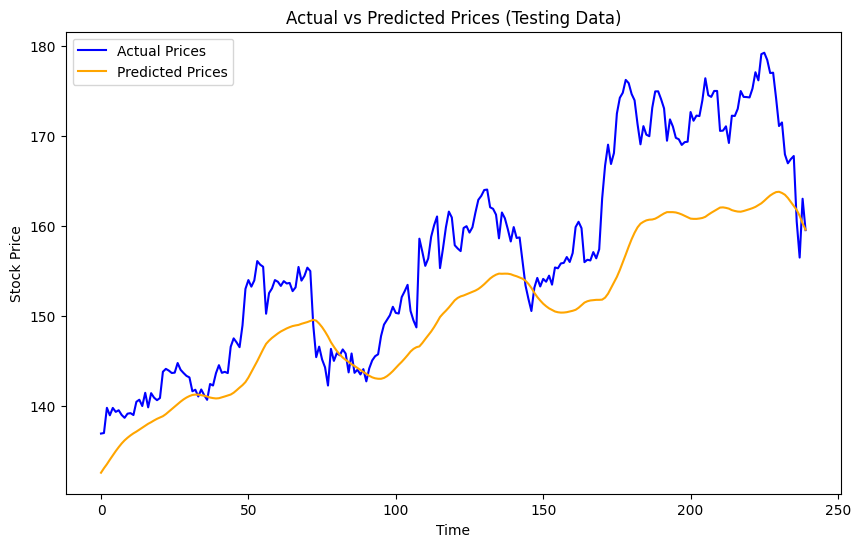

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Data Preprocessing
def load_and_preprocess_data():
    data = pd.read_csv('./all_stocks_5yr.csv')
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data = data[data['Name'] == 'AAPL']  # Example: Use only Apple stock data
    data = data[['close']].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    sequence_length = 60
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return torch.FloatTensor(X_train), torch.FloatTensor(y_train), torch.FloatTensor(X_test), torch.FloatTensor(y_test), scaler

# Main workflow
def main():
    # Load and preprocess data
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data()
    X_train, X_test = X_train.unsqueeze(2), X_test.unsqueeze(2)

    # Initialize model, loss function, and optimizer
    model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Training loop
    epochs = 200
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        # Training predictions
        train_predictions = model(X_train).squeeze().numpy()
        y_train_numpy = y_train.numpy()

        # Testing predictions
        test_predictions = model(X_test).squeeze().numpy()
        y_test_numpy = y_test.numpy()

    # Rescale predictions and actual values back to the original range
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
    y_train_actual = scaler.inverse_transform(y_train_numpy.reshape(-1, 1))

    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test_numpy.reshape(-1, 1))

    # Calculate errors for training and testing
    train_mse = mean_squared_error(y_train_actual, train_predictions)
    train_mae = mean_absolute_error(y_train_actual, train_predictions)
    test_mse = mean_squared_error(y_test_actual, test_predictions)
    test_mae = mean_absolute_error(y_test_actual, test_predictions)

    print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
    print(f"Training Mean Absolute Error (MAE): {train_mae:.4f}")
    print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")
    print(f"Testing Mean Absolute Error (MAE): {test_mae:.4f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label="Actual Prices", color="blue")
    plt.plot(test_predictions, label="Predicted Prices", color="orange")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Prices (Testing Data)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()



Training Mean Squared Error (MSE): 24.3734
Testing Mean Squared Error (MSE): 1678.8305


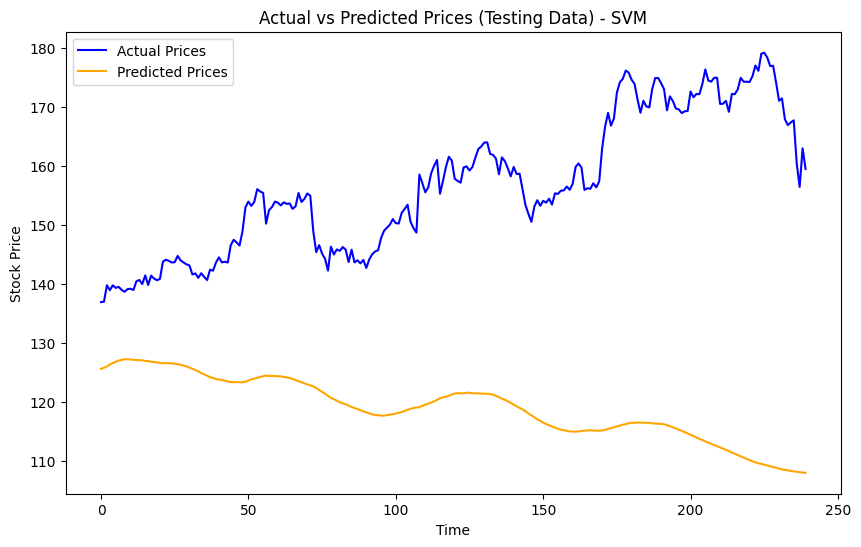

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load and preprocess data
X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data()

# Initialize and train the SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train)

# Make predictions
train_predictions = svm_model.predict(X_train)
test_predictions = svm_model.predict(X_test)

# Rescale predictions and actual values back to the original range
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate errors for training and testing
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)

print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices (Testing Data) - SVM")
plt.legend()
plt.show()

Training Mean Squared Error (MSE): 22.8805
Testing Mean Squared Error (MSE): 49.0270


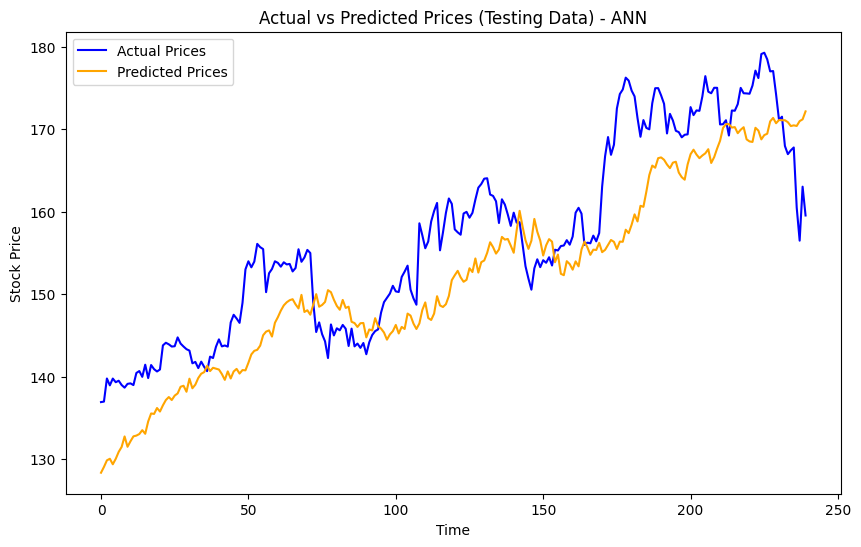

In [5]:
from sklearn.neural_network import MLPRegressor

# Initialize and train the ANN model
ann_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
ann_model.fit(X_train, y_train)

# Make predictions
train_predictions = ann_model.predict(X_train)
test_predictions = ann_model.predict(X_test)

# Rescale predictions and actual values back to the original range
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate errors for training and testing
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)

print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices (Testing Data) - ANN")
plt.legend()
plt.show()